# Importing Packages and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage import transform
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import keras
from keras.utils import to_categorical,Sequence
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Input,MaxPooling2D,Conv2D,BatchNormalization,Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications import resnet50, inception_resnet_v2, vgg16
from keras.applications.inception_resnet_v2 import preprocess_input
from keras import optimizers
from keras.optimizers import Adam,SGD
import os
from imutils import face_utils
import dlib
import cv2
import tarfile
from google.colab.patches import cv2_imshow
def to_rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
import math

Using TensorFlow backend.


 Mouting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Installing packages for colab to drive file transfer

In [0]:
!pip install -U -q PyDrive
!git clone https://github.com/Joshua1989/python_scientific_computing.git
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo

from colab_util import *
drive_handler = GoogleDriveHandler()



     |████████████████████████████████| 993kB 6.9MB/s 
Cloning into 'python_scientific_computing'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.
Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


Getting the ground truth for BIWI dataset

In [0]:
!wget https://data.vision.ee.ethz.ch/cvl/gfanelli/downloads/db_annotations.tgz

--2019-07-04 09:25:57--  https://data.vision.ee.ethz.ch/cvl/gfanelli/downloads/db_annotations.tgz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565563 (552K) [application/x-gzip]
Saving to: ‘db_annotations.tgz’

db_annotations.tgz  100%[===================>] 552.31K   677KB/s    in 0.8s    

2019-07-04 09:25:58 (677 KB/s) - ‘db_annotations.tgz’ saved [565563/565563]



In [0]:
tf = tarfile.open("db_annotations.tgz")
tf.extractall('annotations')

The dataset is large(5.6GB) so it is uploaded to google drive and extracted from there

In [0]:
tf = tarfile.open("gdrive/My Drive/kinect_head_pose_db.tgz")
tf.extractall()

#Getting image and pose parameters file paths

Defining a function for getting filepaths in a list

In [0]:
from os import walk
DATASET_PATH = 'hpdb'
def Loading_filepath(PATH):
    '''
    File directory generator.
    
    ---INPUT---
    
    PATH --- Directory to the dataset
    
    ---OUTPUT---
    
    jpgs --- list of path to images
    
    ** Made for loading BIWI dataset **
    
    '''
    jpgs = []
    for (dirpath,dirnames,filenames) in walk(PATH):
        for filename in filenames[:]:
            if(filename[-3:]=='png'):
                jpgs.append(dirpath+"/"+filename)
    return jpgs

Removing an image whose ground truth doesn't exist

In [0]:
!rm -r 'hpdb/01/frame_00003_rgb.png'

In [0]:
jpg_path = Loading_filepath(DATASET_PATH)
print("Dataset size: ",len(jpg_path))

Dataset size:  15677


In [0]:
pose = []
for i in range(len(jpg_path)):
    pose.append("annotations"+jpg_path[i][4:-7]+"pose.bin")
print("Pose parameter size: ",len(pose))

Pose parameter size:  15677


#Cropping only the faces from images
Using Dlib for extracing only face crops from whole images

In [0]:
!rm -r crop_openpose

rm: cannot remove 'crop_openpose': No such file or directory


In [0]:
!mkdir crop_openpose

In [0]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!7z x "mmod_human_face_detector.dat.bz2"
detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

--2019-07-04 09:31:39--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   688KB/s    in 1.0s    

2019-07-04 09:31:40 (688 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 694709 bytes (679 KiB)

Extracting archive: mmod_human_face_detector.dat.bz2
--
Path = mmod_human_face_detector.dat.bz2
Type = bzip2

  0% - mmod_human_face_detector.dat                                   

Finding  good input  crop sizes for dlib [65:-55,200:540]  are best (this is done so that the background people are not detected by dlib)

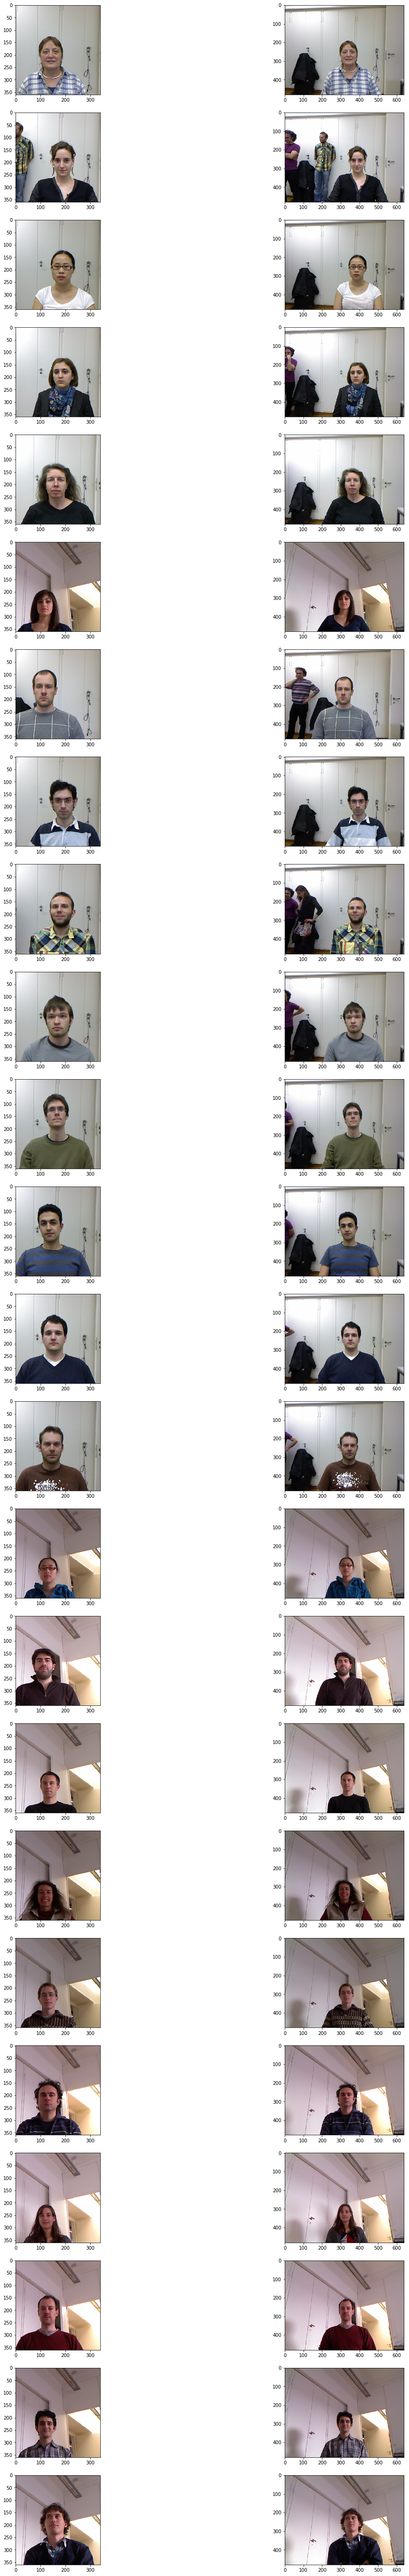

In [0]:
w=10
h=10
fig=plt.figure(figsize=(20, 100))
columns = 2
rows = 24
j = 1
k = 1
for i in range(1, columns*rows +1):
    if i%2 == 0:
        img = plt.imread("hpdb/" + "{:02d}".format(j) + "/frame_00005_rgb.png")
        j+=1
    else:
        img = plt.imread("hpdb/" + "{:02d}".format(k) + "/frame_00005_rgb.png")[65:-55,200:540]
        k+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap = 'gray')
plt.show()

Making folders for the 24 videos

In [0]:
!for i in {01..24}; do mkdir 'crop_openpose/'${i} ;done

Defining fuction for getting face-crops

In [0]:
def GETCROPS(detector,jpg_path):
    '''
    File directory generator.
    
    ---INPUT---
    
    jpg-path --- List of image paths
    
    detector --- Dlib face detection dat file
    
    ---OUTPUT---
    
    All the crop images are saved
    
    ** Made for BIWI dataset **
    
    '''
    jpg_crop_path = []
    pyr = pd.DataFrame(columns = ['image','pitch','yaw','roll'])
    count = 0
    for i in range(len(jpg_path)):
        image = cv2.imread(jpg_path[i])[100:-75,200:540] #Reading images
        dets = detector(image, 0) # 0 is for not upsampling the image
        if len(dets) == 1: # Making sure that only one face is detected (as the images contain people in the background)
            crop_img = image[dets[0].rect.top()-15:dets[0].rect.bottom()+15,dets[0].rect.left()-15:dets[0].rect.right()+15] # cropping the image with 15 extra pixels on all side
            #crop_img = cv2.resize(crop_img,(96,96))
            cv2.imwrite("crop_openpose/" + jpg_path[i][5:] , crop_img) # writing the image to directory
            jpg_crop_path.append("crop_openpose/" + jpg_path[i][5:])
            count = count+1
        if i%1000 == 0:
            print(str(i) + " image reading done")
            print(str(count) + " image writing done")
    print(str(count) + " image written")
    return pyr

In [0]:
pyr = GETCROPS(detector,jpg_path)

0 image reading done
1 image writing done
1000 image reading done
866 image writing done
2000 image reading done
1793 image writing done
3000 image reading done
2769 image writing done
4000 image reading done
3619 image writing done
5000 image reading done
4444 image writing done
6000 image reading done
5410 image writing done
7000 image reading done
6304 image writing done
8000 image reading done
7261 image writing done
9000 image reading done
8167 image writing done
10000 image reading done
9165 image writing done
11000 image reading done
10100 image writing done
12000 image reading done
11086 image writing done
13000 image reading done
12019 image writing done
14000 image reading done
12897 image writing done
15000 image reading done
13810 image writing done
14394 image written


#Installing Openpose

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  #!pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  #from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

Getting all the openpose models for heatmaps extractions

In [0]:
!./openpose/models/getModels.sh
!cp -r pose openpose/models

--2019-07-04 10:01:29--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/body_25/pose_iter_584000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104715850 (100M) [text/plain]
Saving to: ‘pose/body_25/pose_iter_584000.caffemodel’

pose_iter_584000.ca 100%[===================>]  99.86M  15.5MB/s    in 7.6s    

2019-07-04 10:01:38 (13.1 MB/s) - ‘pose/body_25/pose_iter_584000.caffemodel’ saved [104715850/104715850]

--2019-07-04 10:01:38--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
L

#Getting heatmaps

In [0]:
!rm -r openpose/output_heatmaps_folder

rm: cannot remove 'openpose/output_heatmaps_folder': No such file or directory


In [0]:
!mkdir openpose/output_heatmaps_folder

Extracting the heatmaps for every frame of the video

In [0]:
!cd openpose && for i in {01..24}; do ./build/examples/openpose/openpose.bin --image_dir /content/crop_openpose/${i} --model_pose COCO --heatmaps_add_parts -heatmaps_add_bkg --display 0 --render_pose 0 --net_resolution "96x96" --write_heatmaps output_heatmaps_folder/${i}; done

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 31.141490 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 30.093012 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 44.942506 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 46.278607 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto

Getting the heatmaps path

In [0]:
heatmap_paths = Loading_filepath('openpose/output_heatmaps_folder')

Defining function to get the headpose annotations(pitch,yaw and roll)

In [0]:
def GETPYR(heatmap_paths):
    '''
    File directory generator.
    
    ---INPUT---
    
    Hheatmap_path --- List of heatmap paths
    
    ---OUTPUT---
    
    pitch yaw roll iin a dataframe
    
    ** Made for BIWI dataset **
    
    '''
    pyr = pd.DataFrame(columns = ['image','pitch','yaw','roll'])
    for i in range(len(heatmap_paths)):
        with open('annotations'+heatmap_paths[i][31:46]+'_pose.bin', 'rb') as fid: # opening the ground truth file
            data_array = np.fromfile(fid, np.float32)
        para = data_array[3:]
        pyr = pyr.append({'image':'annotations'+heatmap_paths[i][31:46]+'_pose.bin','pitch':para[0],'yaw':para[1],'roll':para[2]},ignore_index = True)
        if i%1000 == 0:
            print(str(i) + " images done")
    print(str(i) + " images done")
    return pyr

In [0]:
pyr = GETPYR(heatmap_paths)

#Model

Custom-data-Generator for the model

In [0]:
from keras.utils import Sequence
class data_gen_train(Sequence):
  
  def __init__(self,train_size,batch_size,heatmap_path,pyr_frame):
    self.batch_length = batch_size
    self.size = train_size
    self.path = heatmap_path
    self.pyr = pyr_frame
  def __getitem__(self, idx):    
    start = idx*self.batch_length
    end = min((idx+1)*self.batch_length, self.size)
    dataset=[]
    pose = []
    for i in range(start,end):
        heatmaps = plt.imread(self.path[i])
        nose = heatmaps[:,0*96:1*96]
        Reye = heatmaps[:,14*96:15*96]
        Leye = heatmaps[:,15*96:16*96]
        Rear = heatmaps[:,16*96:17*96]
        Lear = heatmaps[:,17*96:18*96]
        stacked_heatmaps = np.dstack([nose,Reye,Leye,Rear,Lear])
        dataset.append(stacked_heatmaps)
        pose.append(np.array(self.pyr.iloc[i,1:]))
    return ((np.array(dataset)/255)-0.5)*2,np.array(pose)

  def __len__(self):
    return math.ceil(self.size / self.batch_length)

In [0]:
traingen = data_gen_train(12000,128,heatmap_paths[:12000],pyr[:12000])
valgen = data_gen_train(2049,128,heatmap_paths[12000:],pyr[12000:])

Main model in keras

In [0]:
inpu = Input(shape = (96,96,5))
x = Conv2D(50, (5, 5), activation=None, padding='valid')(inpu)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(50, (5, 5), activation=None, padding='valid')(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(150, (5, 5), activation=None, padding='valid')(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(300, activation='tanh')(x)
x = Dropout(0.3)(x)
x = Dense(300, activation='tanh')(x)
x = Dropout(0.3)(x)
pred = Dense(3,activation='tanh')(x)
model = Model(inputs = inpu,outputs = pred)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 96, 96, 5)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 50)        6300      
_________________________________________________________________
activation_10 (Activation)   (None, 92, 92, 50)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 46, 46, 50)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 46, 46, 50)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 42, 42, 50)        62550     
_________________________________________________________________
activation_11 (Activation)   (None, 42, 42, 50)        0         
__________

Compilation and Training the model

In [0]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(0.00001), metrics=['mae'])

In [0]:
model_saver = keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

In [0]:
model.fit_generator(traingen,validation_data = valgen,epochs = 10,callbacks = [model_saver])